# Current Rebalancing Process

### Step 1: AA comparison in Databricks.


1.  First, the AA comparison is done in DataBricks.
2.  Members are stratfied into 7 demand buckets, ranging from 0 to 2399
3.  Any demand greater than 2400 is considered an outlier, and removed from the analysis.
4. The `PERCENT_RANK` function is used to rank users based on their demand (spending) across different “demand buckets” (like 0-50, 50-100, etc.).
5. However, the current settings apply a fixed percentage cutoff (`<= 1`), meaning it takes the entire user set in these ranges for both control and test groups.


In [ ]:
SELECT
  test_control
  -- primary metrics on incremental revenue: conversion rate, average demand per purchaser
  ,COUNT(DISTINCT upm_id) AS total_members
  ,COUNT(DISTINCT upm_id_buyer) AS buying_members
  ,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
  ,AVG(demand) AS avg_demand
  ,STDDEV(demand) AS std_demand

  -- secondary metrics ON order double click
  ,SUM(demand) / SUM(orders) AS AOV
  ,SUM(demand) / SUM(units) AS AUR
  ,SUM(units) / SUM(orders) AS UPT


FROM demand_bucket db
WHERE (demand < 2400 OR demand IS NULL)  -- remove outliers
AND test_control != 'na'
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
)

GROUP BY 1
ORDER BY 1 DESC;

### Step 2: AA comparison in Excel


1.  The resulting AA comaprison table from Databricks is [pasted into Excel](https://nike.ent.box.com/folder/159196048910?s=rleparlsqxinvaa8m93dipsuaxk1d4fc).

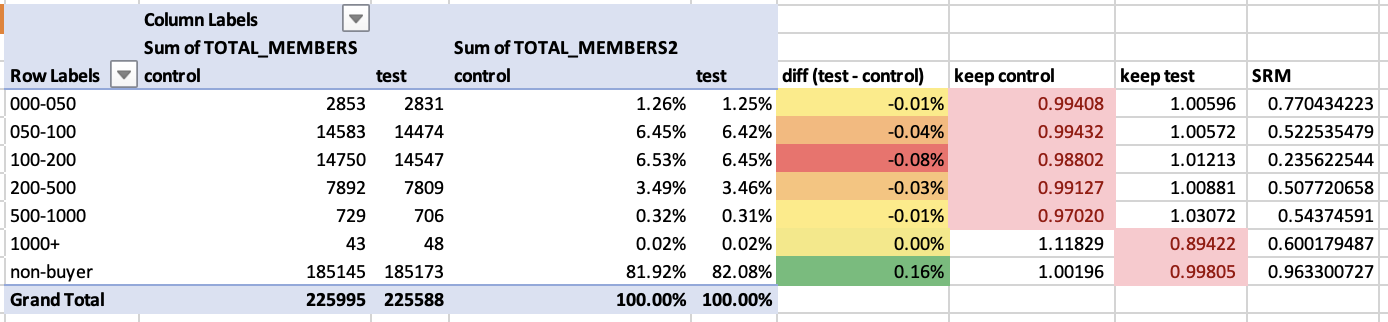

2. The primary difference here is that the `PERCENT_RANK` cutoffs are adjusted.      
    - For example:
     - Instead of including all users in the 0-50 demand range (i.e., `PERCENT_RANK <= 1`), it now only includes a slightly smaller percentage (`PERCENT_RANK <= 0.99408` for the control group).
3. This adjustment is designed to rebalance the dataset and remove a small number of users from specific demand ranges.

### Step 3: Add updated code to Databricks

The updated demand buckets are then added back into the DataBricks code to create a "balanced" dataset for analysis.

In [ ]:
SELECT
  test_control
  -- primary metrics on incremental revenue: conversion rate, average demand per purchaser
  ,COUNT(DISTINCT upm_id) AS total_members
  ,COUNT(DISTINCT upm_id_buyer) AS buying_members
  ,COUNT(DISTINCT upm_id_buyer) / COUNT(DISTINCT upm_id) AS conversion_rate
  ,AVG(demand) AS avg_demand
  ,STDDEV(demand) AS std_demand

  -- secondary metrics ON order double click
  ,SUM(demand) / SUM(orders) AS AOV
  ,SUM(demand) / SUM(units) AS AUR
  ,SUM(units) / SUM(orders) AS UPT


FROM demand_bucket db
WHERE (demand < 2400 OR demand IS NULL)  -- remove outliers
AND test_control != 'na'
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 0.99408)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 0.99432)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 0.98802)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 0.99127)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 0.9702)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 0.89422)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 0.99805)
)

GROUP BY 1
ORDER BY 1 DESC;

### Summary of Overall Process:
- Initially, the A/B test data is extracted from Databricks, including key metrics like conversion rates, average demand, etc.
- The team checks the balance between the test and control groups by evaluating demand in different ranges.
- If there’s imbalance, the team adjusts the dataset by removing users in certain demand buckets (using Excel to decide which users to remove) to create a more balanced comparison.
- The final step involves modifying the SQL code to include the revised `PERCENT_RANK` thresholds, ensuring balanced test and control groups before calculating the metrics again.

## Specific Questions to Further Inform Strategy:
1. **Are there covariates or confounding variables that should be considered?**
  * Balancing might not only be about the primary metric (demand) but also about ensuring that important covariates are equally represented across groups.
2. **What is the goal of rebalancing?**
  * Improve test accuracy, ensure fairness in comparison, etc.
3. **Are there constraints or limitations in the data collection process that might affect rebalancing efforts?**
  * Question for Engineering
4. **Are we open to using statistical techniques like propensity score matching, or do we prefer simpler methods like stratification or oversampling?**

Based on the team's responses to these questions,  tailor the approach to ensure that the dataset is appropriately balanced for analysis.

# NEW Rebalancing Strategy

### Step 1: Import the Dataset

##### Skip this step if you are working with real data

**Create a random dataset**

Create a sample dataset that has a similar distribution to Nike demand data.

Assign *mostly* balanced strata across test and control groups, with a couple non-balanced that differ between 2% and 8%.

In [ ]:
import numpy as np
import pandas as pd

# 1: Create a fake dataset
def create_fake_dataset(num_records=1000, seed=44):
    """
    This function creates a fake dataset that mirrors the distrubtion of Nike NA MarSci demand data.
    i.e. with modes around $150 and a right-skew
    """
    # Seed for reproducibility
    np.random.seed(seed)

    # Generate upm_id as a unique identifier for each record
    upm_id = np.arange(1, num_records + 1)

    # Generate a right-skewed distribution for demand using log-normal with means around 150 and 157
    mode1 = np.random.lognormal(mean=np.log(150), sigma=0.3, size=int(num_records * 0.52))  # 52% of data around 150
    mode2 = np.random.lognormal(mean=np.log(157), sigma=0.5, size=int(num_records * 0.48))  # 48% of data around 157

    demand = np.concatenate([mode1, mode2])
    np.random.shuffle(demand)  # Shuffle to mix the modes well

    # Generate a binary buyer column, where about 20% are buyers
    buyer = np.random.choice([0, 1], size=num_records, p=[0.8, 0.2])

    # Generate test_control group, imbalanced with more control than test
    test_control = np.random.choice(['test', 'control'], size=num_records, p=[0.49, 0.51])

    # Create the DataFrame
    df_aa = pd.DataFrame({
        'upm_id': upm_id,
        'demand': demand,
        'buyer': buyer,
        'test_control': test_control
    })

    return df_aa


# Combine the functions to generate the final dataset
df_aa = create_fake_dataset(num_records=1000)

# Display the first few rows and description of the final dataset
print(df_aa.head())
print(df_aa.describe())

###  Step 2: Perform Basic Descriptive Statistics

####  Get the measures of central tendency

In [ ]:
# Get the measures of central tendency, range, etc

import pandas as pd
import numpy as np
import statistics

# Separate the test and control groups
test_group_aa = df_aa[df_aa['test_control'] == 'test']
control_group_aa = df_aa[df_aa['test_control'] == 'control']

def calculate_central_tendency(numbers):
    mean = statistics.mean(numbers)
    median = statistics.median(numbers)
    try:
        mode = statistics.mode(numbers)
    except statistics.StatisticsError:
        mode = "No unique mode found"
    max_value = max(numbers)
    min_value = min(numbers)
    range_value = max_value - min_value
    return mean, median, mode, max_value, min_value, range_value

# Select the 'demand' column for the test group to calculate its statistics
numbers_test = test_group_aa['demand'].tolist()

mean, median, mode, max_value, min_value, range_value = calculate_central_tendency(numbers_test)

print("Test Group 'demand' Statistics:")
print("Mean:", mean)
print("Median:", median)
print("Mode:", mode)
print("Max value:", max_value)
print("Min value:", min_value)
print("Range:", range_value)

# Repeat the process for the control group if needed
numbers_control = control_group_aa['demand'].tolist()

mean_c, median_c, mode_c, max_value_c, min_value_c, range_value_c = calculate_central_tendency(numbers_control)

print("\nControl Group 'demand' Statistics:")
print("Mean:", mean_c)
print("Median:", median_c)
print("Mode:", mode_c)
print("Max value:", max_value_c)
print("Min value:", min_value_c)
print("Range:", range_value_c)


Test Group 'demand' Statistics:
Mean: 152.52828130622018
Median: 151.13517345251248
Mode: 77.92052017396674
Max value: 333.88526981115353
Min value: 3.0835830365942627
Range: 330.80168677455924

Control Group 'demand' Statistics:
Mean: 156.8550626125708
Median: 151.17327383308782
Mode: 156.14166700043424
Max value: 341.26674453861733
Min value: 2.220528369448033
Range: 339.04621616916927


#### Visualize Distribution for Demand

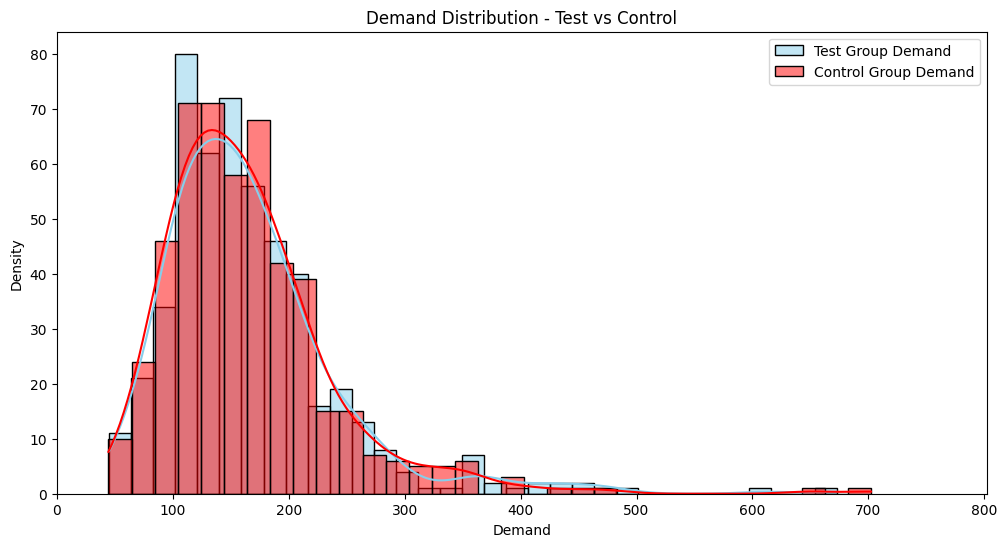

In [2]:
## Demand

# %python
import matplotlib.pyplot as plt
import seaborn as sns

# Separate the test and control groups
test_group_aa = df_aa[df_aa['test_control'] == 'test']
control_group_aa = df_aa[df_aa['test_control'] == 'control']

num_bins = 20

# Plotting Demand Distribution
plt.figure(figsize=(12, 6))
sns.histplot(test_group_aa['demand'].dropna(), color="skyblue", label="Test Group Demand", kde=True)
sns.histplot(control_group_aa['demand'].dropna(), color="red", label="Control Group Demand", kde=True)
plt.title('Demand Distribution - Test vs Control')
plt.xlabel('Demand')
plt.ylabel('Density')
plt.xlim(0, df_aa['demand'].max()+ 100)
plt.legend()
plt.show()

### Step 3: Rebalance - by Stratification

#### Stratification

* This function first prepares the data by excluding NaN values and calculating strata based on the specified metric (demand).
* It then calculates the proportion of samples within each stratum for both the test and control groups.
* By comparing these proportions, the function identifies strata where the difference exceeds a defined tolerance (e.g., 1%).
* Strata with differences beyond this tolerance are considered imbalanced.
* The function prints out details of any imbalanced strata, based on the proportion of samples they contain within each group.


##### Assign Strata

In [3]:
import numpy as np
import pandas as pd

# Function to assign strata based on 'demand'
# All non-buyers assigned to stratum 8

def assign_strata(df_aa, metric='demand', num_strata=8):
    """
    This function calculates percentile boundaries and assigns strata based on the 'demand' metric.
    Non-buyers are assigned to stratum 8.

    Parameters:
    - df_aa: The input DataFrame.
    - metric: The column representing the metric to assign strata.
    - num_strata: The number of strata to create.

    Returns:
    - df_aa: The DataFrame with an added 'stratum' column.
    """

    # Exclude rows where the metric is NaN
    df_aa_clean = df_aa.dropna(subset=[metric])

    # Split the data into buyers and non-buyers
    buyers = df_aa_clean[df_aa_clean['buyer'] == 1].copy()
    non_buyers = df_aa_clean[df_aa_clean['buyer'] == 0].copy()

    # Calculate percentile boundaries to evenly split the buyers into num_strata parts
    percentile_values = np.linspace(0, 100, num=num_strata + 1)[1:-1]
    percentiles_combined = np.percentile(buyers[metric], percentile_values)

    # Assign strata based on calculated percentiles for buyers
    buyers['stratum'] = np.digitize(buyers[metric], percentiles_combined)

    # Assign stratum 8 for all non-buyers
    non_buyers['stratum'] = num_strata

    # Concatenate the buyers and non-buyers back into a single DataFrame
    df_aa = pd.concat([buyers, non_buyers])

    return df_aa

# Example usage
df_aa = assign_strata(df_aa, metric='demand', num_strata=8)

# Display the first few rows of the dataset
print(df_aa.head())


    upm_id      demand  buyer test_control  stratum
3        4  262.847448      1      control        7
5        6  170.066339      1      control        4
7        8  131.365052      1         test        2
12      13  176.543909      1      control        5
33      34  229.953171      1         test        6


##### Check Imbalance

In [4]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of each stratum for the test and control groups, compares them,
    and identifies any imbalances that exceed the specified tolerance.
    """
    # Calculate proportions of each stratum for test and control groups
    test_stratum_proportion = df_test['stratum'].value_counts(normalize=True).sort_index()
    control_stratum_proportion = df_control['stratum'].value_counts(normalize=True).sort_index()

    print("\nTest Group Strata Proportions:\n", test_stratum_proportion)
    print("Control Group Strata Proportions:\n", control_stratum_proportion)

    imbalanced_strata = []
    for stratum in test_stratum_proportion.index:
        test_prop = test_stratum_proportion.get(stratum, 0)
        control_prop = control_stratum_proportion.get(stratum, 0)
        proportion_diff = abs(test_prop - control_prop)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_proportion': test_prop,
                'control_proportion': control_prop,
                'difference': proportion_diff
            })

    # Print imbalanced strata if found
    if imbalanced_strata:
        print("\nImbalanced strata found (difference exceeds tolerance of {}):".format(tolerance))
        for imbalance in imbalanced_strata:
            print(f"Stratum {imbalance['stratum']}: Test Proportion = {imbalance['test_proportion']:.4f}, Control Proportion = {imbalance['control_proportion']:.4f}, Difference = {imbalance['difference']:.4f}")
    else:
        print("\nNo imbalanced strata found (all differences within tolerance).")

    return imbalanced_strata

# Example usage
df_test = df_aa[df_aa['test_control'] == 'test']
df_control = df_aa[df_aa['test_control'] == 'control']

# Call the function with a specified tolerance
check_imbalance(df_test, df_control, tolerance=0.01)



Test Group Strata Proportions:
 stratum
0    0.015873
1    0.023810
2    0.025794
3    0.017857
4    0.013889
5    0.025794
6    0.027778
7    0.027778
8    0.821429
Name: proportion, dtype: float64
Control Group Strata Proportions:
 stratum
0    0.032258
1    0.022177
2    0.022177
3    0.028226
4    0.032258
5    0.022177
6    0.018145
7    0.020161
8    0.802419
Name: proportion, dtype: float64

Imbalanced strata found (difference exceeds tolerance of 0.01):
Stratum 0: Test Proportion = 0.0159, Control Proportion = 0.0323, Difference = 0.0164
Stratum 3: Test Proportion = 0.0179, Control Proportion = 0.0282, Difference = 0.0104
Stratum 4: Test Proportion = 0.0139, Control Proportion = 0.0323, Difference = 0.0184
Stratum 8: Test Proportion = 0.8214, Control Proportion = 0.8024, Difference = 0.0190


[{'stratum': 0,
  'test_proportion': 0.015873015873015872,
  'control_proportion': 0.03225806451612903,
  'difference': 0.01638504864311316},
 {'stratum': 3,
  'test_proportion': 0.017857142857142856,
  'control_proportion': 0.028225806451612902,
  'difference': 0.010368663594470046},
 {'stratum': 4,
  'test_proportion': 0.013888888888888888,
  'control_proportion': 0.03225806451612903,
  'difference': 0.018369175627240143},
 {'stratum': 8,
  'test_proportion': 0.8214285714285714,
  'control_proportion': 0.8024193548387096,
  'difference': 0.019009216589861766}]

##### Rebalancing



In [5]:
import numpy as np
import pandas as pd

# Function to calculate proportions and check for imbalances within each stratum
def check_imbalance(df_test, df_control, tolerance):
    """
    This function calculates the proportions of test and control records within each stratum
    and identifies any imbalances that exceed the specified tolerance.
    """
    imbalanced_strata = []
    strata = sorted(df_test['stratum'].unique())  # List of all strata

    for stratum in strata:
        test_count = df_test[df_test['stratum'] == stratum].shape[0]
        control_count = df_control[df_control['stratum'] == stratum].shape[0]

        # Calculate proportion difference relative to the total count in that stratum
        total_count = test_count + control_count
        if total_count == 0:
            continue  # Skip if no records in this stratum

        test_proportion = test_count / total_count
        control_proportion = control_count / total_count
        proportion_diff = abs(test_proportion - control_proportion)

        if proportion_diff > tolerance:
            imbalanced_strata.append({
                'stratum': stratum,
                'test_count': test_count,
                'control_count': control_count,
                'difference': proportion_diff
            })

    return imbalanced_strata

# Rebalance function (adjust within each stratum)
def rebalance(df_aa, metric='demand', num_strata=8, tolerance=0.01, max_iterations=10):
    """
    This function assesses which strata have imbalanced test and control group sizes
    and directly adjusts the groups to ensure they are balanced within the specified tolerance.
    Returns a single balanced dataframe.
    """
    df_aa_clean = df_aa.dropna(subset=[metric])  # Exclude rows where 'demand' (or other metric) is NaN

    # Separate test and control groups
    df_test = df_aa_clean[df_aa_clean['test_control'] == 'test'].copy()
    df_control = df_aa_clean[df_aa_clean['test_control'] == 'control'].copy()

    # Assign strata based on the specified metric
    df_test = assign_strata(df_test, metric=metric, num_strata=num_strata)
    df_control = assign_strata(df_control, metric=metric, num_strata=num_strata)

    iteration_count = 0

    # Iteratively rebalance until no imbalanced strata remain or max iterations is reached
    while iteration_count < max_iterations:
        iteration_count += 1

        # Identify imbalanced strata
        imbalanced_strata = check_imbalance(df_test, df_control, tolerance)

        # If no imbalanced strata are found, break the loop
        if not imbalanced_strata:
            print(f"No imbalanced strata found after {iteration_count} iteration(s). Rebalancing complete.")
            break

        # Rebalance each imbalanced stratum
        for imbalance in imbalanced_strata:
            stratum = imbalance['stratum']
            test_count = imbalance['test_count']
            control_count = imbalance['control_count']

            # Determine which group has more records and remove excess
            if test_count > control_count:
                records_to_remove = test_count - control_count
                indices_to_remove = np.random.choice(df_test[df_test['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_test = df_test.drop(indices_to_remove)
                print(f"Iteration {iteration_count}: Removed {records_to_remove} records from test group in stratum {stratum}")
            elif control_count > test_count:
                records_to_remove = control_count - test_count
                indices_to_remove = np.random.choice(df_control[df_control['stratum'] == stratum].index, size=records_to_remove, replace=False)
                df_control = df_control.drop(indices_to_remove)
                print(f"Iteration {iteration_count}: Removed {records_to_remove} records from control group in stratum {stratum}")

    # Concatenate the balanced test and control groups back into a single dataframe
    df_aa_balanced = pd.concat([df_test, df_control]).sort_values(by='upm_id').reset_index(drop=True)

    return df_aa_balanced

# Example call to the function
df_aa_balanced = rebalance(df_aa, 'demand', num_strata=8, tolerance=0.01, max_iterations=10)

# Check for imbalance again
imbalanced_strata = check_imbalance(df_aa_balanced[df_aa_balanced['test_control'] == 'test'],
                                    df_aa_balanced[df_aa_balanced['test_control'] == 'control'],
                                    tolerance=0.01)
if not imbalanced_strata:
    print("No imbalanced strata found. The dataset is balanced.")
    print(df_aa_balanced.head())
else:
    print(f"Imbalanced strata after adjustment: {imbalanced_strata}")


Iteration 1: Removed 1 records from control group in stratum 0
Iteration 1: Removed 1 records from control group in stratum 1
Iteration 1: Removed 1 records from control group in stratum 2
Iteration 1: Removed 1 records from control group in stratum 3
Iteration 1: Removed 1 records from control group in stratum 4
Iteration 1: Removed 1 records from control group in stratum 5
Iteration 1: Removed 1 records from control group in stratum 6
Iteration 1: Removed 1 records from control group in stratum 7
Iteration 1: Removed 16 records from test group in stratum 8
No imbalanced strata found after 2 iteration(s). Rebalancing complete.
No imbalanced strata found. The dataset is balanced.
   upm_id      demand  buyer test_control  stratum
0       1  170.630809      0         test        8
1       2  223.701124      0         test        8
2       3  144.368121      0         test        8
3       4  262.847448      1      control        7
4       5  159.766397      0      control        8


In [ ]:
print(df_aa_balanced.head())
print(df_control_adjusted.head())

### Step 4: Load `balanced_df` to SQL table

In [ ]:
%python

# Allow Table in Personal Schema to Overwrite Existing
# https://kb.databricks.com/jobs/spark-overwrite-cancel
spark.conf.set("spark.sql.legacy.allowNonEmptyLocationInCTAS","true")

# Clear all widgets
dbutils.widgets.removeAll()

# Create widgets for user input
dbutils.widgets.text("adhoc_s3_loc", "s3://ngap2-user-data/gck")
dbutils.widgets.text("user_db", "user_db")
dbutils.widgets.text("test_num", "test_num")

In [ ]:
%python

# Convert pandas DataFrame to Spark DataFrame
balanced_spark_df = spark.createDataFrame(balanced_df)

# Fetch widget values
adhoc_s3_loc = dbutils.widgets.get("adhoc_s3_loc")
user_db = dbutils.widgets.get("user_db")
test_num = dbutils.widgets.get("test_num")

# Construct the path and table name
# path = '${hivevar:adhoc_s3_loc}/${hivevar:user_db}/${hivevar:to_tbl}_msmt_aa_balanced'
path = f"{adhoc_s3_loc}/{user_db}/{test_num}_msmt"
table_name = f"{user_db}.{test_num}_msmt_aa_balanced"

sql_query = f"""DROP TABLE IF EXISTS path.table_name"""

# Save the Spark DataFrame as an external table at the specified path
df_spark_aa.write.mode("overwrite").option("path", path).saveAsTable(table_name)
# balanced_spark_df.write.option("path", path).saveAsTable('${hivevar:user_db}.msmt_aa_balanced')



# Other Methods for Rebalancing

### Percent Rank /w SQL

In [ ]:
demand_bucket AS (
  SELECT tct.upm_id
  , tct.test_control
  , aa.upm_id as upm_id_aa_buyer
  , aa.demand
  , aa.orders
  , aa.units
  , CASE
    WHEN aa.demand = 0 OR aa.demand IS NULL THEN 'non-buyer'
    WHEN aa.demand < 50 THEN '000-050'
    WHEN aa.demand < 100 THEN '050-100'
    WHEN aa.demand < 200 THEN '100-200'
    WHEN aa.demand < 500 THEN '200-500'
    WHEN aa.demand < 1000 THEN '500-1000'
    WHEN aa.demand >=1000 THEN '1000+'
    END AS demand_per_buyer_bucket
  , PERCENT_RANK() OVER (
    PARTITION BY test_control
    , CASE
      WHEN aa.demand = 0 OR aa.demand IS NULL THEN 'non-buyer'
      WHEN aa.demand < 50 THEN '000-050'
      WHEN aa.demand < 100 THEN '050-100'
      WHEN aa.demand < 200 THEN '100-200'
      WHEN aa.demand < 500 THEN '200-500'
      WHEN aa.demand < 1000 THEN '500-1000'
      WHEN aa.demand >=1000 THEN '1000+'
      END ORDER BY RANDOM(0)
    ) AS percent_rank
  FROM test_control_table tct
  LEFT JOIN aa_purchase aa ON tct.upm_id = aa.upm_id
)

, balanced_aud_aa as (
  SELECT DISTINCT upm_id
  FROM demand_bucket db
  -- remove outliers
  WHERE (demand < 2400 OR demand IS NULL)
-- To rebalance, paste text block from template in place of defaults
AND ((test_control = 'control' and (demand > 0 and demand <= 50) and PERCENT_RANK <= 0.99328)
OR (test_control = 'control' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 0.99324)
OR (test_control = 'control' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 0.98904)
OR (test_control = 'control' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 0.99102)
OR (test_control = 'control' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 0.96862)
OR (test_control = 'control' and (demand > 1000) and PERCENT_RANK <= 1)
OR (test_control = 'control' and (demand = 0 or demand is null) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand >0 and demand <= 50) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 50 and demand <= 100) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 100 and demand <= 200) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 200 and demand <= 500) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 500 and demand <= 1000) and PERCENT_RANK <= 1)
OR (test_control = 'test' and (demand > 1000) and PERCENT_RANK <= 0.93321)
OR (test_control = 'test' and (demand = 0 or demand is null) and PERCENT_RANK <= 0.99801)
	)

### Percent Rank /w Python

This code continues with the original code usage of the percent rank function, but implemented in a randomized way to reduce bias.

#### Assigning by Perc Rank (OG Method)

In [ ]:
#%python
def bucket_and_rank(df, metric='demand', num_buckets=8):
    """
    Assigns demand buckets based on percentiles and then assigns a random rank within each bucket.

    Args:
    df (pd.DataFrame): The input DataFrame.
    metric (str): The column name for the metric to bucket by.
    num_buckets (int): The number of buckets to divide the data into.

    Returns:
    pd.DataFrame: The modified DataFrame with demand buckets and random ranks.
    """
    # Calculate demand buckets based on percentiles
    percentiles = np.percentile(df[metric], np.linspace(0, 100, num_buckets + 1)[1:-1])
    df['demand_bucket'] = np.digitize(df[metric], percentiles)

    # Assign a random rank within each demand bucket
    def assign_random_rank(sub_df):
        sub_df['random_rank'] = np.random.rand(len(sub_df))
        sub_df['random_rank'] = sub_df['random_rank'].rank(method='first') / len(sub_df)
        return sub_df

    # Apply the function to each group
    df = df.groupby('demand_bucket', group_keys=False).apply(assign_random_rank)
    return df

# Apply the function to your DataFrame
df_aa_ranked = bucket_and_rank(df_aa, 'demand', num_buckets=8)

# Display the first few rows to verify the output
df_aa_ranked.head()

,upm_id,demand,buyer,test_control,demand_bucket,random_rank
0,1,243.514657,1,control,3,0.728
1,2,330.708335,0,control,6,0.096
2,3,66.428424,0,control,0,0.288
3,4,75.758046,1,test,1,0.480
4,5,82.384666,0,test,2,0.576


#### Identifying Imbalance by Perc Rank (OG Method)

In [ ]:
# %python
import pandas as pd
import numpy as np

def assess_balance_using_precomputed_buckets(df, tolerance=0.01):
    df_test = df_aa_ranked[df_aa_ranked['test_control'] == 'test'].copy()
    df_control = df_aa_ranked[df_aa_ranked['test_control'] == 'control'].copy()

    mismatches = []
    for bucket in sorted(df_aa_ranked['demand_bucket'].unique()):
        if bucket in df_test['demand_bucket'].values and bucket in df_control['demand_bucket'].values:
            avg_rank_test = df_test[df_test['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control[df_control['demand_bucket'] == bucket]['random_rank'].mean()

            if abs(avg_rank_test - avg_rank_control) > tolerance:
                mismatches.append(bucket)
                print(f"Demand bucket {bucket} is imbalanced. Test group average rank: {avg_rank_test:.2%}, Control group average rank: {avg_rank_control:.2%}.")

    if not mismatches:
        print("All demand buckets are balanced across test and control groups within the defined tolerance.")

    return mismatches

# First, apply the bucket_and_rank function to df_aa
df_aa_processed = bucket_and_rank(df_aa, 'demand', num_buckets=8)

# Then, assess balance using the processed DataFrame
mismatches = assess_balance_using_precomputed_buckets(df_aa_processed, tolerance=0.01)
print("Identified mismatches in demand buckets:", mismatches)



Demand bucket 1 is imbalanced. Test group average rank: 51.05%, Control group average rank: 49.90%.
Demand bucket 2 is imbalanced. Test group average rank: 47.59%, Control group average rank: 52.09%.
Demand bucket 3 is imbalanced. Test group average rank: 53.19%, Control group average rank: 48.72%.
Demand bucket 4 is imbalanced. Test group average rank: 51.58%, Control group average rank: 49.59%.
Demand bucket 5 is imbalanced. Test group average rank: 56.07%, Control group average rank: 47.42%.
Demand bucket 6 is imbalanced. Test group average rank: 53.13%, Control group average rank: 48.52%.
Demand bucket 7 is imbalanced. Test group average rank: 53.71%, Control group average rank: 48.54%.
Identified mismatches in demand buckets: [1, 2, 3, 4, 5, 6, 7]


#### Balancing by Perc Rank (OG Method)

In [ ]:
# Splitting df_aa_processed into test and control groups
df_test = df_aa_processed[df_aa_processed['test_control'] == 'test']
df_control = df_aa_processed[df_aa_processed['test_control'] == 'control']

# Rebalancing the dataset based on identified mismatches
balanced_df = rebalance_strata_based_on_mismatches(df_test, df_control, mismatches)

# Optionally, inspect the balanced DataFrame
print(balanced_df.head())


     upm_id     demand  buyer test_control  demand_bucket  random_rank
52       53  61.223306      1         test              0        0.112
59       60  59.493366      0         test              0        0.704
109     110  66.532063      0         test              0        0.712
123     124  60.214780      0         test              0        0.528
128     129  65.184913      1         test              0        0.024


#### Check post Perc Rank balancing

In [ ]:
def check_balance_post_rebalancing(balanced_df, tolerance=0.01):
    """
    Checks the balance of a DataFrame after rebalancing efforts have been made. It assesses
    balance by comparing the test and control groups within each demand bucket.

    Parameters:
    - balanced_df: DataFrame containing the test and control group data after rebalancing.
    - tolerance: The tolerance for differences in average percent ranks.

    Returns:
    - Prints out the results of the balance check, indicating whether the dataset is balanced.
    """
    # Separate the balanced DataFrame back into test and control groups
    df_test_balanced = balanced_df[balanced_df['test_control'] == 'test']
    df_control_balanced = balanced_df[balanced_df['test_control'] == 'control']

    # Initialize list for tracking mismatches post-rebalancing
    new_mismatches = []

    print("Reassessing balance after adjustments...")

    # Iterate through each demand bucket to assess balance
    for bucket in sorted(balanced_df['demand_bucket'].unique()):
        # Check if both test and control groups have entries in this bucket
        if bucket in df_test_balanced['demand_bucket'].values and bucket in df_control_balanced['demand_bucket'].values:
            # Compute average random rank for each bucket in test and control
            avg_rank_test = df_test_balanced[df_test_balanced['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control_balanced[df_control_balanced['demand_bucket'] == bucket]['random_rank'].mean()

            # Calculate the difference as a percentage
            diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

            # Always print the balance assessment for visibility
            print(f"Bucket {bucket}: Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

            # Identify mismatches based on the tolerance for difference in average ranks
            if abs(avg_rank_test - avg_rank_control) > tolerance:
                new_mismatches.append(bucket)

    # Summary message post assessment
    if not new_mismatches:
        print("\nAll demand buckets are balanced across test and control groups within the defined tolerance.")
    else:
        print("\nSome imbalances still exist after rebalancing. Identified mismatches in demand buckets:", new_mismatches)


check_balance_post_rebalancing(balanced_df, tolerance=0.02)

Reassessing balance after adjustments...
Bucket 0: Test Avg Rank: 48.23%, Control Avg Rank: 51.50%, Difference: -3.27%.
Bucket 1: Test Avg Rank: 48.59%, Control Avg Rank: 49.29%, Difference: -0.70%.
Bucket 2: Test Avg Rank: 51.17%, Control Avg Rank: 48.36%, Difference: 2.81%.
Bucket 3: Test Avg Rank: 48.78%, Control Avg Rank: 52.34%, Difference: -3.56%.
Bucket 4: Test Avg Rank: 48.52%, Control Avg Rank: 49.87%, Difference: -1.35%.
Bucket 5: Test Avg Rank: 47.80%, Control Avg Rank: 51.26%, Difference: -3.46%.
Bucket 6: Test Avg Rank: 45.87%, Control Avg Rank: 55.36%, Difference: -9.49%.
Bucket 7: Test Avg Rank: 48.44%, Control Avg Rank: 54.01%, Difference: -5.56%.

Some imbalances still exist after rebalancing. Identified mismatches in demand buckets: [0, 2, 3, 5, 6, 7]


#### Calculate Standardized Mean Difference

In [ ]:
def calculate_smd(df, group_column, value_column):
    """
    Calculate Standardized Mean Differences (SMD) between two groups within the DataFrame.

    Calculating the difference in means between the test and control groups within each demand bucket,
    divided by the standard deviation of the combined groups.
    A decrease in SMD after rebalancing indicates improved balance.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_column (str): The column name indicating the group (test or control).
    value_column (str): The column name of the values to compare (e.g., 'demand').

    Returns:
    A DataFrame with SMD values for each demand bucket.
    """
    results = []
    for bucket in sorted(df['demand_bucket'].unique()):
        df_bucket = df[df['demand_bucket'] == bucket]
        mean_test = df_bucket[df_bucket[group_column] == 'test'][value_column].mean()
        mean_control = df_bucket[df_bucket[group_column] == 'control'][value_column].mean()
        pooled_std = np.sqrt(((df_bucket[value_column].std() ** 2) + (df_bucket[value_column].std() ** 2)) / 2)
        smd = (mean_test - mean_control) / pooled_std if pooled_std > 0 else 0
        results.append({'demand_bucket': bucket, 'SMD': smd})

    return pd.DataFrame(results)

smd_before = calculate_smd(df_aa, 'test_control', 'demand')

smd_after = calculate_smd(balanced_df, 'test_control', 'demand')

smd_comparison = smd_before.merge(smd_after, on='demand_bucket', suffixes=('_before', '_after'))

print(smd_comparison)

   demand_bucket  SMD_before  SMD_after
0              0   -0.281070  -0.281070
1              1    0.182568   0.257128
2              2    0.191817   0.248677
3              3   -0.174060  -0.013010
4              4   -0.369913  -0.368451
5              5   -0.068393  -0.061332
6              6    0.029894   0.114758
7              7    0.179063   0.059397


#### Complete Rank and Bucket Function

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Bucket and Rank
def bucket_and_rank(df, metric='demand', num_buckets=8):
    print("Starting bucketing and ranking...")
    percentiles = np.percentile(df[metric], np.linspace(0, 100, num_buckets + 1)[1:-1])
    df['demand_bucket'] = np.digitize(df[metric], percentiles)

    def assign_random_rank(sub_df):
        sub_df['random_rank'] = np.random.rand(len(sub_df))
        sub_df['random_rank'] = sub_df['random_rank'].rank(method='first') / len(sub_df)
        return sub_df

    df = df.groupby('demand_bucket', group_keys=False).apply(assign_random_rank)
    print("Bucketing and ranking complete.\n")
    return df

# Step 2: Assess Initial Balance
def assess_balance_using_precomputed_buckets(df, tolerance=0.01):
    print("Assessing initial balance using precomputed buckets...")
    mismatches = []
    for bucket in sorted(df['demand_bucket'].unique()):
        df_test = df[(df['test_control'] == 'test') & (df['demand_bucket'] == bucket)]
        df_control = df[(df['test_control'] == 'control') & (df['demand_bucket'] == bucket)]
        avg_rank_test = df_test['random_rank'].mean() if not df_test.empty else 0
        avg_rank_control = df_control['random_rank'].mean() if not df_control.empty else 0

        diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

        if abs(avg_rank_test - avg_rank_control) > tolerance:
            mismatches.append(bucket)
            print(f"Bucket {bucket} is imbalanced. Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")
        else:
            print(f"Bucket {bucket} is balanced. Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

    if not mismatches:
        print("All demand buckets are balanced within the defined tolerance.")
    else:
        print("Imbalances found in buckets:", mismatches)
    print("\n")
    return mismatches

# Step 3: Calculate Initial Proportions (No Changes Needed)
def calculate_initial_proportions(df):
    print("Calculating initial proportions...")
    counts = df.groupby(['demand_bucket', 'test_control']).size().unstack(fill_value=0)
    total = counts.sum(axis=1)
    counts['test_prop'] = counts['test'] / total
    counts['control_prop'] = counts['control'] / total
    counts['imbalance'] = abs(counts['test_prop'] - counts['control_prop'])
    print("Initial proportions calculated.\n")
    return counts


# Step 5: Calculate Weights for Balance
def calculate_weights_for_balance(df, tolerance=0.02):
    print("Calculating weights for each sample to achieve balance...")
    proportions = calculate_initial_proportions(df)

    # Initialize weights to 1 as default
    df['weight'] = 1.0

    for bucket, row in proportions.iterrows():
        imbalance = row['test_prop'] - row['control_prop']
        if abs(imbalance) > tolerance:
            # Adjust weights inversely proportional to imbalance magnitude
            weight_adjustment_test = 1 - (imbalance if imbalance > 0 else -imbalance) / 2
            weight_adjustment_control = 1 + (imbalance if imbalance > 0 else -imbalance) / 2

            df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'test'), 'weight'] = weight_adjustment_test
            df.loc[(df['demand_bucket'] == bucket) & (df['test_control'] == 'control'), 'weight'] = weight_adjustment_control

            print(f"Adjusted weights in bucket {bucket} due to imbalance of {imbalance*100:.2f}%.")

    print("Weight calculations complete.\n")
    return df

# Step 6: Re-assess Balance After Adjustments (Using the Same Function as Step 2)
def check_balance_post_rebalancing(balanced_df, tolerance=0.01):
    """
    Checks the balance of a DataFrame after rebalancing efforts have been made. It assesses
    balance by comparing the test and control groups within each demand bucket.

    Parameters:
    - balanced_df: DataFrame containing the test and control group data after rebalancing.
    - tolerance: The tolerance for differences in average percent ranks.

    Returns:
    - Prints out the results of the balance check, indicating whether the dataset is balanced.
    """
    # Separate the balanced DataFrame back into test and control groups
    df_test_balanced = balanced_df[balanced_df['test_control'] == 'test']
    df_control_balanced = balanced_df[balanced_df['test_control'] == 'control']

    # Initialize list for tracking mismatches post-rebalancing
    new_mismatches = []

    print("Reassessing balance after adjustments...")

    # Iterate through each demand bucket to assess balance
    for bucket in sorted(balanced_df['demand_bucket'].unique()):
        # Check if both test and control groups have entries in this bucket
        if bucket in df_test_balanced['demand_bucket'].values and bucket in df_control_balanced['demand_bucket'].values:
            # Compute average random rank for each bucket in test and control
            avg_rank_test = df_test_balanced[df_test_balanced['demand_bucket'] == bucket]['random_rank'].mean()
            avg_rank_control = df_control_balanced[df_control_balanced['demand_bucket'] == bucket]['random_rank'].mean()

            # Calculate the difference as a percentage
            diff_percentage = (avg_rank_test - avg_rank_control) * 100  # Convert to percentage

            # Always print the balance assessment for visibility
            print(f"Bucket {bucket}: Test Avg Rank: {avg_rank_test:.2%}, Control Avg Rank: {avg_rank_control:.2%}, Difference: {diff_percentage:.2f}%.")

            # Identify mismatches based on the tolerance for difference in average ranks
            if abs(avg_rank_test - avg_rank_control) > tolerance:
                new_mismatches.append(bucket)

    # Summary message post assessment
    if not new_mismatches:
        print("\nAll demand buckets are balanced across test and control groups within the defined tolerance.")
    else:
        print("\nSome imbalances still exist after rebalancing. Identified mismatches in demand buckets:", new_mismatches)


# check_balance_post_rebalancing(balanced_df, tolerance=0.02)


print("Processing initial DataFrame...")
df_aa_processed = bucket_and_rank(df_aa, 'demand', num_buckets=8)

print("Initial balance assessment...")
initial_mismatches = assess_balance_using_precomputed_buckets(df_aa_processed, tolerance=0.01)

# If needed, here would be the place for any rank adjustment logic (Optional, based on your strategy)

print("Calculating weights to achieve finer balance...")
df_aa_weighted = calculate_weights_for_balance(df_aa_processed, tolerance=0.02)

print("Reassessing balance after applying weights...")
# It's important to adjust the function to consider weights in the balance assessment,
# which might require modification to how balance is calculated or interpreted based on weights.
reassessed_mismatches = assess_balance_using_precomputed_buckets(df_aa_weighted, tolerance=0.01)


Processing initial DataFrame...
Starting bucketing and ranking...
Bucketing and ranking complete.

Initial balance assessment...
Assessing initial balance using precomputed buckets...
Bucket 0 is imbalanced. Test Avg Rank: 43.98%, Control Avg Rank: 53.65%, Difference: -9.67%.
Bucket 1 is imbalanced. Test Avg Rank: 44.04%, Control Avg Rank: 55.23%, Difference: -11.19%.
Bucket 2 is imbalanced. Test Avg Rank: 44.97%, Control Avg Rank: 53.67%, Difference: -8.70%.
Bucket 3 is imbalanced. Test Avg Rank: 48.44%, Control Avg Rank: 51.58%, Difference: -3.14%.
Bucket 4 is imbalanced. Test Avg Rank: 55.76%, Control Avg Rank: 46.70%, Difference: 9.06%.
Bucket 5 is balanced. Test Avg Rank: 50.16%, Control Avg Rank: 50.53%, Difference: -0.37%.
Bucket 6 is imbalanced. Test Avg Rank: 51.50%, Control Avg Rank: 49.64%, Difference: 1.85%.
Bucket 7 is imbalanced. Test Avg Rank: 44.34%, Control Avg Rank: 53.81%, Difference: -9.47%.
Imbalances found in buckets: [0, 1, 2, 3, 4, 6, 7]


Calculating weights to

## Propensity Scores

1. **Calculate Propensity Scores**
  * First, calculate the propensity score for each user, which is the probability of being in the test group versus the control group based on observed covariates.
  * This can be done using logistic regression, where the dependent variable is the group assignment (test vs. control), and the independent variables are the covariates we wish to control for (e.g., demographic variables, prior purchase behavior, etc.).

2. Match Users Based on Propensity Scores
  * After calculating the scores, match users in the test group with similar users in the control group based on their propensity scores.
  * The goal is to create pairs or sets of users who are similar in their probability of being in the test group but are in different groups.
  There are several methods for matching, such as nearest neighbor matching, caliper matching,optimal matching, etc.

3. Analyze the Matched Data
  * Once we have our matched dataset, we can compare the outcomes (e.g., Demand per Buyer) between the test and control groups within these matched pairs or sets.
  * This comparison aims to estimate the treatment effect (impact of being in the test group) on the outcome, minimizing the bias introduced by confounders.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from causalinference import CausalModel

# Assuming df_aa includes some covariates for calculating propensity scores
covariates = ['covariate1', 'covariate2']  # Replace these with our actual covariate column names

# Standardize covariates
scaler = StandardScaler()
df_aa[covariates] = scaler.fit_transform(df_aa[covariates])

# Define the treatment variable (1 for test group, 0 for control group)
df_aa['treatment'] = np.where(df_aa['test_control'] == 'test', 1, 0)

# Calculate propensity scores using logistic regression
logistic = LogisticRegression()
logistic.fit(df_aa[covariates], df_aa['treatment'])
df_aa['propensity_score'] = logistic.predict_proba(df_aa[covariates])[:, 1]

# Perform matching - (differs depending on matching library/method used)
# For causal inference library, we're using the CausalModel class for matching

causal = CausalModel(Y=df_aa['Demand'].values, D=df_aa['treatment'].values, X=df_aa['propensity_score'].values)
causal.est_via_matching(bias_adj=True)

# Analyze the matched data


## Nearest Neighbors Matching

In [ ]:
# install scikit-learn

from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Initialize the Nearest Neighbors model.
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')

# Separate test and control groups
df_test = df_aa[df_aa['test_control'] == 'test']
df_control = df_aa[df_aa['test_control'] == 'control']

# Fit the model to the control group's feature(s) we're matching on.
# Here we're using 'demand' and 'buyer', but this can be a list of many features.
nn.fit(df_control[['demand', 'buyer']])

# Find the nearest neighbor in the control group for each member in the test group.
distances, indices = nn.kneighbors(df_test[['demand', 'buyer']])

# Create a new DataFrame for matched control units
# Using indices.flatten() to get a 1D array of indices for control units
df_control_matched = df_control.iloc[indices.flatten()]

# Keep track of which test unit each control unit was matched to:
df_control_matched['matched_to_test_index'] = indices.flatten()

# Combine matched test and control units for further analysis
# Reset index if you plan to merge or concatenate
df_matched = pd.concat([df_test.reset_index(drop=True), df_control_matched.reset_index(drop=True)], axis=1)

# df_matched now contains each test unit alongside its matched control unit


<ipython-input-44-6c1da025114a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control_matched['matched_to_test_index'] = indices.flatten()
